In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import math

In [2]:
import strategy.trendlabeling as tlb

In [3]:
import getdata as gd
from pandas_datareader import data as pdr
import yfinance as yf

import afml.filters.filters as flt 
import afml.labeling.triplebarrier as tbar
import afml.util.volatility as vol
import features.bars as bars  
import features.marketindicators as mkt
import afml.features.fracdiff as fdiff
from afml.ensemble.sb_bagging import SequentiallyBootstrappedBaggingClassifier
from afml.sample_weights.attribution import get_weights_by_return, get_weights_by_time_decay
from afml.feature_importance.importance import mean_decrease_impurity, mean_decrease_accuracy, single_feature_importance, plot_feature_importance
from afml.cross_validation.cross_validation import PurgedKFold, ml_cross_val_score

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.utils import resample
from sklearn.utils import shuffle

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

## Import Dataset

In [6]:
df = pd.read_csv('ticker.csv')
df.index = pd.to_datetime(df['Date'])
df = df.drop('Date', axis=1)
df.dropna(axis=0, how='any', inplace=True)

index_SPY = pd.read_csv('spy.csv')
index_SPY.index = pd.to_datetime(index_SPY['Date'])
index_SPY = index_SPY.drop('Date', axis=1)
index_SPY.dropna(axis=0, how='any', inplace=True)


In [7]:
# # download dataframe

# yf.pdr_override()

# def get_yf_daily(ticker, startdate, enddate, years):
#     df = pd.DataFrame()
#     for i in range(years):
#         start = startdate.replace(startdate.year-i).strftime('%Y-%m-%d')
#         end = enddate.replace(enddate.year-i).strftime('%Y-%m-%d')
#         thisdf = pdr.get_data_yahoo(ticker, start=start, end=end)
#         df= pd.concat([df, thisdf], axis= 0)
#         print('Complete {} {}'.format(ticker, enddate.year-i))
#     return df

# years = 10
# startdate= datetime.date(2021, 1, 1)
# enddate = datetime.date(2021, 12, 31)

# df = get_yf_daily('STBA', startdate, enddate, years).sort_index(ascending=True)
# index_SPY = get_yf_daily('SPY', startdate, enddate, years).sort_index(ascending=True)
# #index_COMP = get_yf_daily('COMP', startdate, enddate, years)


## Form Dollar Bars

In [8]:
# construct the input data
_df = df.reset_index()
trades = _df[['Date', 'Adj Close', 'Volume']].to_numpy()

# define the dollar value to sample the data
frequency = _df.Volume.mean()*20
#frequency = df['Volume'].resample('D').sum().mean()/10.0

# generate the dollar bars
dollar_bars = bars.generate_dollarbars(trades, frequency=frequency) 


In [9]:
# construct the input data
_index_SPY = index_SPY.reset_index()
trades_SPY = _index_SPY[['Date', 'Adj Close', 'Volume']].to_numpy()

# define the dollar value to sample the data
frequency_SPY = _index_SPY.Volume.mean()*20
#frequency = df['Volume'].resample('D').sum().mean()/10.0

# generate the dollar bars
dollar_bars_SPY = bars.generate_dollarbars(trades_SPY, frequency=frequency_SPY) 


## Get Labels: Trend Scanning method

In [10]:
# convert Adj Close to numpy
#time_series = df['Adj Close'].to_numpy()
time_series = dollar_bars.close.to_numpy()
window_size_max= 7

# get trend scanning labels
label_output = pd.DataFrame(tlb.get_trend_scanning_labels(time_series=time_series, 
                                             window_size_max=window_size_max, 
                                             threshold=0.0,
                                             opp_sign_ct=3,
                                             side='both'), 
                            index= dollar_bars.index[window_size_max-1:])

dollar_bars = dollar_bars.join(label_output, how='outer')

dollar_bars['label'] = dollar_bars['label'].shift(1) 
dollar_bars['slope'] = dollar_bars['slope'].shift(1) 

In [11]:
print(dollar_bars['label'].value_counts())

 1.0    875
-1.0    805
Name: label, dtype: int64


## Get Labels: Simple moving average cross over strategy

In [12]:
# # need to cite here ...

# # compute moving averages
# fast_window = 20
# slow_window = 50

# dollar_bars['fast_mavg'] = dollar_bars['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
# dollar_bars['slow_mavg'] = dollar_bars['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

# # Compute sides
# dollar_bars['side'] = np.nan

# long_signals = dollar_bars['fast_mavg'] >= dollar_bars['slow_mavg'] 
# short_signals = dollar_bars['fast_mavg'] < dollar_bars['slow_mavg'] 
# dollar_bars.loc[long_signals, 'side'] = 1
# dollar_bars.loc[short_signals, 'side'] = -1

# # Remove Look ahead biase by lagging the signal
# dollar_bars['side'] = dollar_bars['side'].shift(1) 

In [13]:
# print(dollar_bars['side'].value_counts())


## Filter Events using CUSUM Filter

We will then predict what will happen if the event is triggered, based on the 'side' signal from the Trend Following Strategy 

In [14]:
close = dollar_bars.close.copy()

In [15]:
# get Daily Volatility
dailyVolatility = vol.getDailyVol(close, span=50)

# apply cusum filter to identify events as cumulative log return passed threshold
#tEvents = flt.getTEvents(close, h=dailyVolatility.mean()*0.5)
tEvents = flt.cusum_filter(close, threshold=dailyVolatility.mean()*0.5, signal=None)

# Define vertical barrier - subjective judgment
num_days = 5

t1 = tbar.add_vertical_barrier(tEvents, close, num_days=num_days)

In [16]:
# get side labels from trend following method
side_labels = []

for dt in dollar_bars.index:
    side_labels.append(dollar_bars.loc[dt]['label'])

side_labels = pd.Series(side_labels, index=dollar_bars.index)

## Create Trade or Not Trade labels using Triple Barrier Method

In [17]:
# Define upper and lower horizontal barriers
# set profit and stop loss ratio
ptsl = [1,1]

# select minRet
minRet = 0.015 # requires at least 1.5% percent return

# Run in single-threaded mode on Windows
import platform, os
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = os.cpu_count() - 1
    
events = tbar.get_events(dollar_bars.close, 
                         t_events=tEvents, 
                         pt_sl=ptsl, 
                         target=dailyVolatility, 
                         min_ret=minRet, 
                         num_threads=cpus, 
                         vertical_barrier_times=t1,
                         side_prediction=side_labels).dropna()

labels = tbar.get_bins(triple_barrier_events = events, close=close)

# Drop underpopulated labels
clean_labels  = tbar.drop_labels(labels)
print(clean_labels.bin.value_counts())

0    654
1    219
Name: bin, dtype: int64


## Results of Secondary Model without features

In [18]:
primary_forecast = pd.DataFrame(clean_labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       654
           1       0.25      1.00      0.40       219

    accuracy                           0.25       873
   macro avg       0.13      0.50      0.20       873
weighted avg       0.06      0.25      0.10       873

Confusion Matrix
[[  0 654]
 [  0 219]]

Accuracy
0.2508591065292096


## Features: Technical Indicators

In [19]:
dollar_bars.head()

,open,high,low,close,volume,slope,label
time,,,,,,,
2012-01-04,14.060812,14.152808,14.060812,14.152808,156200.0,NaN,NaN
2012-01-06,14.471251,14.471251,14.294340,14.294340,177200.0,NaN,NaN
2012-01-10,14.414642,14.584470,14.414642,14.584470,142400.0,NaN,NaN
2012-01-13,14.605696,14.676466,14.492473,14.492473,142400.0,NaN,NaN
2012-01-18,14.372177,14.549086,14.372177,14.549086,141100.0,NaN,NaN


In [20]:
# Log Returns
dollar_bars['log_ret'] = np.log(dollar_bars['close']).diff().shift(1)

# Momentum
dollar_bars['mom1'] = dollar_bars['close'].pct_change(periods=1).shift(1)
dollar_bars['mom2'] = dollar_bars['close'].pct_change(periods=2).shift(1)
dollar_bars['mom3'] = dollar_bars['close'].pct_change(periods=3).shift(1)
dollar_bars['mom4'] = dollar_bars['close'].pct_change(periods=4).shift(1)
dollar_bars['mom5'] = dollar_bars['close'].pct_change(periods=5).shift(1)

# Volatility
dollar_bars['volatility_50'] = dollar_bars['log_ret'].rolling(window=50, min_periods=50, center=False).std().shift(1)
dollar_bars['volatility_31'] = dollar_bars['log_ret'].rolling(window=31, min_periods=31, center=False).std().shift(1)
dollar_bars['volatility_15'] = dollar_bars['log_ret'].rolling(window=15, min_periods=15, center=False).std().shift(1)

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

dollar_bars['autocorr_1'] = dollar_bars['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False).shift(1)
dollar_bars['autocorr_2'] = dollar_bars['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False).shift(1)
dollar_bars['autocorr_3'] = dollar_bars['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False).shift(1)
dollar_bars['autocorr_4'] = dollar_bars['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False).shift(1)
dollar_bars['autocorr_5'] = dollar_bars['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False).shift(1)

# Get the various log -t returns
dollar_bars['log_t1'] = dollar_bars['log_ret'].shift(1).shift(1)
dollar_bars['log_t2'] = dollar_bars['log_ret'].shift(2).shift(1)
dollar_bars['log_t3'] = dollar_bars['log_ret'].shift(3).shift(1)
dollar_bars['log_t4'] = dollar_bars['log_ret'].shift(4).shift(1)
dollar_bars['log_t5'] = dollar_bars['log_ret'].shift(5).shift(1)

# relative strength SPY at various -t
dollar_bars['rs_SPY_t1'] = mkt.get_relative_strength(dollar_bars.close, dollar_bars_SPY.close).shift(1)
dollar_bars['rs_SPY_t2'] = mkt.get_relative_strength(dollar_bars.close, dollar_bars_SPY.close).shift(2)
dollar_bars['rs_SPY_t3'] = mkt.get_relative_strength(dollar_bars.close, dollar_bars_SPY.close).shift(3)
dollar_bars['rs_SPY_t4'] = mkt.get_relative_strength(dollar_bars.close, dollar_bars_SPY.close).shift(4)
dollar_bars['rs_SPY_t5'] = mkt.get_relative_strength(dollar_bars.close, dollar_bars_SPY.close).shift(5)


#Correct lookahead bias
#dollar_bars['fast_mavg'] = dollar_bars['fast_mavg'].shift(1)
#dollar_bars['slow_mavg'] = dollar_bars['slow_mavg'].shift(1)
# Remove Look ahead biase by lagging the signal


#### Fitting a Meta model

Use features: volatility, serial correlation, relative strength to S&P and COMP

In [21]:
dollar_bars = dollar_bars.join(clean_labels['bin']).dropna()

In [22]:
X = dollar_bars.iloc[:, :-1]
y = dollar_bars.iloc[:, -1]

In [23]:
# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'volume',
        #'fast_mavg', 'slow_mavg',
        ], 
        axis=1, inplace=True)


C:\Users\choit\AppData\Local\Temp\ipykernel_14168\2648678673.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['open', 'high', 'low', 'close', 'volume',


#### Technical Features

In [24]:
# # Re compute sides
# raw_data['side'] = np.nan

# long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
# short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']

# raw_data.loc[long_signals, 'side'] = 1
# raw_data.loc[short_signals, 'side'] = -1

In [25]:
# # fractional differentiated log dollar bar prices

# # cumulative sum of stock log-prices
# ticker_log_cumsum = np.log(dollar_bars.close).cumsum()

# # frac diff 1 time
# dfx1 = fdiff.frac_diff_ffd(ticker_log_cumsum.to_frame(), diff_amt=1).dropna()

# # apply cumsum filter
# dfx1_close = dfx1.close.copy()
# df_tEvents = flt.getTEvents(dfx1_close, h=dfx1.std().iat[0]*2)

# # fracDiff value feature
# frac_diff_feat = dfx1.loc[df_tEvents] 


In [26]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=RANDOM_STATE)

## Sample Weights

In [27]:
# training data sample weights

return_based_sample_weights = get_weights_by_return(events.loc[X_train.index], dollar_bars.loc[X_train.index, 'close'])
time_based_sample_weights = get_weights_by_time_decay(events.loc[X_train.index], dollar_bars.loc[X_train.index, 'close'], decay=0.5)

# test data sample weights

return_based_sample_weights_test = get_weights_by_return(events.loc[X_test.index], dollar_bars.loc[X_test.index, 'close'])
time_based_sample_weights_test = get_weights_by_time_decay(events.loc[X_test.index], dollar_bars.loc[X_test.index, 'close'], decay=0.5)

2023-03-27 14:09:48.484984 100.0% num_concurrent_events done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-27 14:09:49.638745 100.0% _apply_weight_by_return done after 0.02 minutes. Remaining 0.0 minutes.
2023-03-27 14:09:50.796843 100.0% num_concurrent_events done after 0.02 minutes. Remaining 0.0 minutes.
2023-03-27 14:09:51.909508 100.0% _get_average_uniqueness done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-27 14:09:53.025639 100.0% num_concurrent_events done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-27 14:09:54.141263 100.0% _apply_weight_by_return done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-27 14:09:55.278572 100.0% num_concurrent_events done after 0.01 minutes. Remaining 0.0 minutes.
2023-03-27 14:09:56.392839 100.0% _get_average_uniqueness done after 0.01 minutes. Remaining 0.0 minutes.


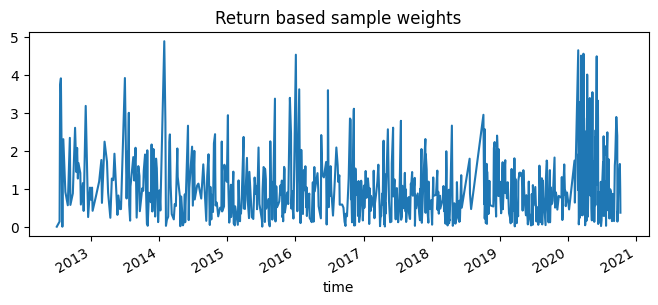

In [28]:
plt.figure(figsize=(8,3))
plt.title('Return based sample weights')
return_based_sample_weights.plot()
plt.show()

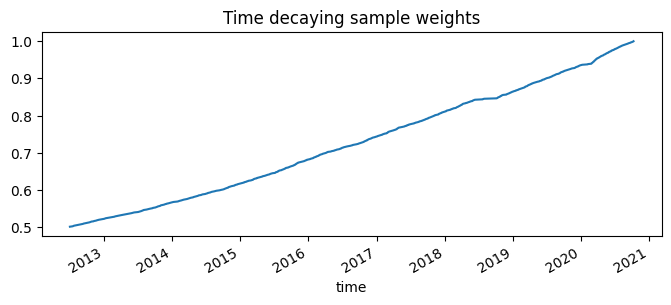

In [29]:
plt.figure(figsize=(8,3))
plt.title('Time decaying sample weights')
time_based_sample_weights.plot()
plt.show()

## Cross-Validation 

In [30]:
def get_clf_best_param_cv(type, clf, X_train, y_train, cv_gen, scoring, sample_weight, scaler=StandardScaler()):
    t0 = 0.0
    t1 = 0.0

    best_param_dict = {}
    best_param_dict['type'] = type
    best_param_dict['top_model'] = None
    best_param_dict['max_cross_val_score'] = -np.inf
    best_param_dict['max_cross_val_score_recall'] = -np.inf
    best_param_dict['max_cross_val_score_precision'] = -np.inf
    best_param_dict['max_cross_val_score_accuracy'] = -np.inf
    best_param_dict['run_time'] = 0.0

    col = X_train.columns.to_list()
    idx = X_train.index

    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=col, index=idx)

    t0 = time.time()
    temp_score_base, temp_recall, temp_precision, temp_accuracy = ml_cross_val_score(clf, X_train_scaled, y_train, cv_gen, scoring=scoring, sample_weight=sample_weight)
    t1 = time.time()
    
    if temp_score_base.mean() > best_param_dict['max_cross_val_score']:
        best_param_dict['top_model'] = clf
        best_param_dict['max_cross_val_score'] = temp_score_base.mean()
        best_param_dict['max_cross_val_score_recall'] = temp_recall.mean()
        best_param_dict['max_cross_val_score_precision'] = temp_precision.mean()
        best_param_dict['max_cross_val_score_accuracy'] = temp_accuracy.mean()
        best_param_dict['run_time'] = t1-t0    
    
    return best_param_dict

def perform_grid_search(X_train, y_train, cv_gen, scoring, parameters, events, dollar_bars, type='standard', sample_weight=None, RANDOM_STATE=42):
    """
    Grid search using Purged CV without using sample weights in fit(). Returns top model and top score
    """

    if type=='SVC' or type=='seq_boot_SVC':
        for C in parameters['C']:
            for gamma in parameters['gamma']:

                clf_SVC = SVC(C=C,
                                gamma=gamma,
                                class_weight='balanced',
                                kernel='linear',
                                random_state=RANDOM_STATE)

                if type =='SVC':
                    clf = clf_SVC
                elif type == 'seq_boot_SVC':
                    clf = SequentiallyBootstrappedBaggingClassifier(samples_info_sets=events.loc[X_train.index].t1, ## events
                                                                price_bars = dollar_bars.loc[X_train.index.min():X_train.index.max(), 'close'], ## df
                                                                estimator=clf_SVC, 
                                                                random_state=RANDOM_STATE, n_jobs=-1, oob_score=False,
                                                                max_features=1.)

                # get best param dict   
                best_param_dict = get_clf_best_param_cv(type, clf, X_train, y_train, cv_gen, scoring=scoring, sample_weight=sample_weight)


    else:    
        for m_depth in parameters['max_depth']:
            for n_est in parameters['n_estimators']:
                clf_base = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE, 
                                                max_depth=m_depth, class_weight='balanced')

                if type == 'standard_bagging':
                    clf = BaggingClassifier(n_estimators=n_est, 
                                            estimator=clf_base, 
                                            random_state=RANDOM_STATE, n_jobs=-1, 
                                            oob_score=False, max_features=1.)
                elif type == 'random_forest':
                    clf = RandomForestClassifier(n_estimators=n_est, 
                                                max_depth=m_depth, 
                                                random_state=RANDOM_STATE, 
                                                n_jobs=-1, 
                                                oob_score=False, 
                                                criterion='entropy',
                                                class_weight='balanced_subsample', 
                                                max_features=1.)
                elif type == 'sequential_bootstrapping':
                    clf = SequentiallyBootstrappedBaggingClassifier(samples_info_sets=events.loc[X_train.index].t1, ## events
                                                                    price_bars = dollar_bars.loc[X_train.index.min():X_train.index.max(), 'close'], ## df
                                                                    estimator=clf_base, 
                                                                    n_estimators=n_est, 
                                                                    random_state=RANDOM_STATE, 
                                                                    n_jobs=-1, 
                                                                    oob_score=False,
                                                                    max_features=1.)
                
                # get best param dict   
                best_param_dict = get_clf_best_param_cv(type, clf, X_train, y_train, cv_gen, scoring=scoring, sample_weight=sample_weight)

    return best_param_dict

In [31]:
parameters = {'max_depth':[3, 5, 7, 9],
              'n_estimators':[10, 50, 100, 250, 500],
              'C':[#100,
                   1000],
              'gamma':[#0.001,
                       0.0001], 
              }

In [32]:
n_splits=4

cv_gen_standard = KFold(n_splits)
cv_gen_purged = PurgedKFold(n_splits=n_splits, samples_info_sets=events.loc[X_train.index].t1)

In [33]:
warnings.filterwarnings('ignore')

In [34]:

selected_models = ['standard_bagging', 
                   'random_forest', 
                   #'sequential_bootstrapping', 
                   'SVC', 
                   #'seq_boot_SVC'
                   # RNN
                   # BERT
                   ]

model_metrics = pd.DataFrame(columns = ['type', 'top_model', 'max_cross_val_score', 'max_cross_val_score_recall', 'max_cross_val_score_precision', 'max_cross_val_score_accuracy','run_time'])


for clf in selected_models:
    best_params = perform_grid_search(X_train, y_train, cv_gen_purged, 'f1', parameters, events, dollar_bars, type=clf, sample_weight=return_based_sample_weights.values)
    model_metrics = model_metrics.append(best_params, ignore_index = True)  
    print('Completed {}'.format(clf))


Completed seq_boot_SVC


In [35]:
model_metrics

,type,top_model,max_cross_val_score,max_cross_val_score_recall,max_cross_val_score_precision,max_cross_val_score_accuracy,run_time
0,seq_boot_SVC,"(SVC(C=1000, class_weight='balanced', gamma=0....",0.350853,0.453717,0.301542,0.522305,141.77362


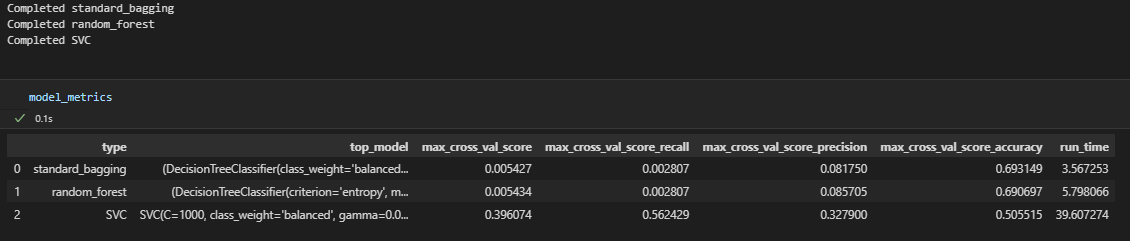

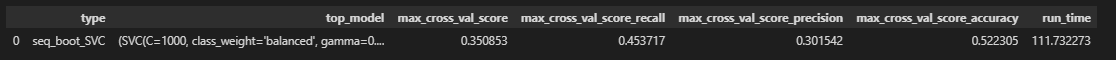

In [36]:
top_model = model_metrics.sort_values(['max_cross_val_score']).tail(1)['top_model'].squeeze()
top_model

SequentiallyBootstrappedBaggingClassifier(estimator=SVC(C=1000,
                                                        class_weight='balanced',
                                                        gamma=0.0001,
                                                        kernel='linear',
                                                        random_state=42),
                                          n_jobs=-1,
                                          price_bars=time
2012-07-02    13.329280
2012-07-17    13.630911
2012-07-20    13.092282
2012-07-24    12.050933
2012-08-01    11.512304
                ...    
2020-09-30    16.062206
2020-10-02    16.670553
2020-10-05    17.424181
2020-10-07    17.778294
2020-10-08    18.105167
Name: close, Length: 673, dtype: float64,
                                          random_state=42,
                                          samples_info_sets=time
2012-07-02   2012-07-09
2012-07-17   2012-07-20
2012-07-20   2012-07-24
2012-07-24   2012-08-01
2012-08-01   2012-08-06
                ...    
2020-09-30   2020-10-05
2020-10-02   2020-10-05
2020-10-05   2020-10-12
2020-10-07   2020-10-12
2020-10-08   2020-10-13
Name: t1, Length: 673, dtype: datetime64[ns])

In [37]:
best_SVC = model_metrics[model_metrics['type'] == 'seq_boot_SVC']['top_model'].squeeze()
best_SVC

SequentiallyBootstrappedBaggingClassifier(estimator=SVC(C=1000,
                                                        class_weight='balanced',
                                                        gamma=0.0001,
                                                        kernel='linear',
                                                        random_state=42),
                                          n_jobs=-1,
                                          price_bars=time
2012-07-02    13.329280
2012-07-17    13.630911
2012-07-20    13.092282
2012-07-24    12.050933
2012-08-01    11.512304
                ...    
2020-09-30    16.062206
2020-10-02    16.670553
2020-10-05    17.424181
2020-10-07    17.778294
2020-10-08    18.105167
Name: close, Length: 673, dtype: float64,
                                          random_state=42,
                                          samples_info_sets=time
2012-07-02   2012-07-09
2012-07-17   2012-07-20
2012-07-20   2012-07-24
2012-07-24   2012-08-01
2012-08-01   2012-08-06
                ...    
2020-09-30   2020-10-05
2020-10-02   2020-10-05
2020-10-05   2020-10-12
2020-10-07   2020-10-12
2020-10-08   2020-10-13
Name: t1, Length: 673, dtype: datetime64[ns])

## Feature Importance

The SVC classifier does not provide a direct wat to obtain feature importances. However, we can use the coefficients of the hyperplane that seperates the classes to estimate the importance of each feature. The magnitude of the coefficient corresponds to the importance of the corresponding feature in the classification.

In [40]:
# Get coefficients of hyperplane
coef = best_SVC.coef_.ravel()
indices = np.argsort(coef)
coef = coef[indices]
feature_names = X_train.columns.to_list()
feature_names = [feature_names[i] for i in indices]

# Plot the coefficients as horizontal bars
plt.barh(range(len(coef)), coef, color='b')

# Add a horizontal line to indicate standard deviation
plt.plot([0, 0], [len(coef), -1], 'r--', lw=2)

# Set the y-axis labels
plt.yticks(range(len(coef)), feature_names)

# Set the x-axis label and title
plt.xlabel('Coefficient')
plt.title('Feature Importance')

plt.show()


AttributeError: 'SequentiallyBootstrappedBaggingClassifier' object has no attribute 'coef_'

In [39]:
# Get coefficients of hyperplane
coef = top_model.coef_.ravel()
indices = np.argsort(coef)
coef = coef[indices]
feature_names = X_train.columns.to_list()
feature_names = [feature_names[i] for i in indices]

# Plot the coefficients as horizontal bars
plt.barh(range(len(coef)), coef, color='b')

# Add a horizontal line to indicate standard deviation
plt.plot([0, 0], [len(coef), -1], 'r--', lw=2)

# Set the y-axis labels
plt.yticks(range(len(coef)), feature_names)

# Set the x-axis label and title
plt.xlabel('Coefficient')
plt.title('Feature Importance')

plt.show()

AttributeError: 'SequentiallyBootstrappedBaggingClassifier' object has no attribute 'coef_'

This codes below are for tress based Feature Importance

In [ ]:
# # MDI, MDA, SFI feature importance
# mdi_feat_imp = mean_decrease_impurity(top_model, X_train.columns)
# mda_feat_imp = mean_decrease_accuracy(top_model, X_train, y_train, cv_gen_purged, scoring='f1', sample_weight=sw_train)
# sfi_feat_imp = single_feature_importance(top_model, X_train, y_train, cv_gen_purged, scoring='f1', sample_weight=sw_train)

In [ ]:
# plot_feature_importance(mdi_feat_imp, 0, 0)

In [ ]:
# plot_feature_importance(mda_feat_imp, 0, 0)

In [ ]:
# plot_feature_importance(sfi_feat_imp, 0, 0)

## Top Model Metrics

In [ ]:
# from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, f1_score

# #best_SVC_fitted = best_SVC.fit(X_train, y_train, sample_weight=return_based_sample_weights.values)
# #y_pred = best_SVC_fitted.predict(X_test)
# y_pred = best_SVC.predict(X_test)
# print(classification_report(y_test, y_pred))

# ConfusionMatrixDisplay.from_estimator(best_SVC, X_test, y_test)
# plt.show()

# SVC_ROC = RocCurveDisplay.from_estimator(best_SVC, X_test, y_test)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.title('ROC curve')
# plt.show()

              precision    recall  f1-score   support

         0.0       0.70      0.47      0.56       128
         1.0       0.18      0.37      0.24        41

    accuracy                           0.44       169
   macro avg       0.44      0.42      0.40       169
weighted avg       0.57      0.44      0.48       169



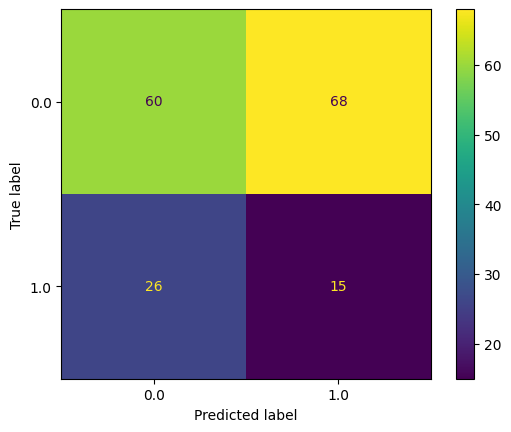

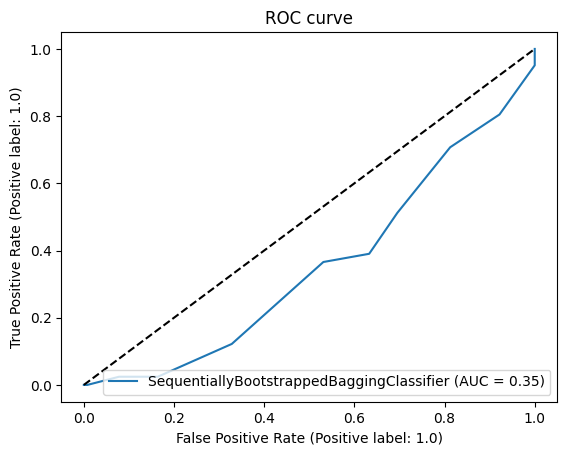

In [41]:
y_pred = top_model.predict(X_test)
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(top_model, X_test, y_test)
plt.show()

RocCurveDisplay.from_estimator(top_model, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.show()

## Backtest

In [42]:
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}, index=X_test.index)
X_test_with_results = pd.concat([X_test, results_df], axis=1)
merged_df = pd.merge(X_test_with_results, clean_labels, left_index=True, right_index=True)

In [43]:
# trade returns of predicted trades 
transaction_cost = 0.01
slippage = 0.005

merged_df['y_pred_trade_ret'] = 0
merged_df.loc[merged_df['y_pred'] == 1, 'y_pred_trade_ret'] = merged_df.loc[merged_df['y_pred'] == 1, 'ret'] - (transaction_cost + slippage)
merged_df_sorted = merged_df.sort_values('t1')


In [44]:
# cumulative returns
merged_df_sorted['cumulative_returns'] = (merged_df_sorted['y_pred_trade_ret'] + 1).cumprod() - 1
cum_rtn_plot = merged_df_sorted.groupby('t1')['cumulative_returns', 'y_pred_trade_ret'].last()
cum_rtn_plot = pd.DataFrame(cum_rtn_plot)

### Cumulative Returns

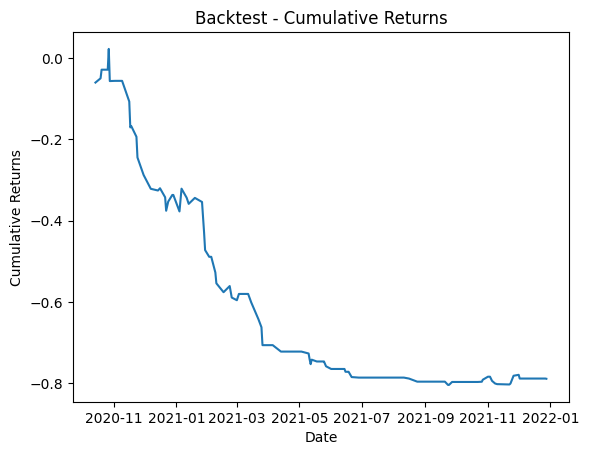

In [45]:

   # Visualize the results
plt.plot(cum_rtn_plot.index, cum_rtn_plot.cumulative_returns)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest - Cumulative Returns')
plt.show()

#### Sharpe Ratio

In [46]:
# https://ycharts.com/indicators/3_year_treasury_rate Long Term Average Rist Free Rate as at Mar 24, 2023
daily_risk_free_rate = 0.036 / 252  # https://ycharts.com/indicators/3_year_treasury_rate Long Term Average Rist Free Rate as at Mar 24, 2023

# calculate daily returns for each trading day
trading_days = pd.DataFrame(pd.bdate_range(start=merged_df.index.min(), end=cum_rtn_plot.index.max(), freq='B'), columns=['trading_days'])
trading_days.index =trading_days['trading_days']
sharpe_df = pd.merge(trading_days, cum_rtn_plot['cumulative_returns'], left_index=True, right_index=True, how='left').fillna(method='ffill')
sharpe_df['cumulative_returns'] = sharpe_df['cumulative_returns'].fillna(0)
sharpe_df['daily_returns'] = sharpe_df['cumulative_returns'].diff().fillna(0)
sharpe_df['day'] = 1
sharpe_df['trading_days'] = sharpe_df['day'].cumsum()
sharpe_df['rolling_std_dev'] =sharpe_df['daily_returns'].expanding().std(ddof=0)
sharpe_df['cumulative_sharpe'] = ((sharpe_df['cumulative_returns']/sharpe_df['trading_days'])-daily_risk_free_rate) / sharpe_df['rolling_std_dev'] * np.sqrt(252)
sharpe_df = sharpe_df.fillna(0)


In [47]:
# Calculate the average daily return and standard deviation of daily returns
avg_daily_return = np.mean(sharpe_df.daily_returns)
std_daily_return = np.std(sharpe_df.daily_returns)

# Calculate the Sharpe ratio
daily_risk_free_rate = 0.036 / 252  
sharpe_ratio = round((avg_daily_return - daily_risk_free_rate) / std_daily_return * np.sqrt(252), 2)

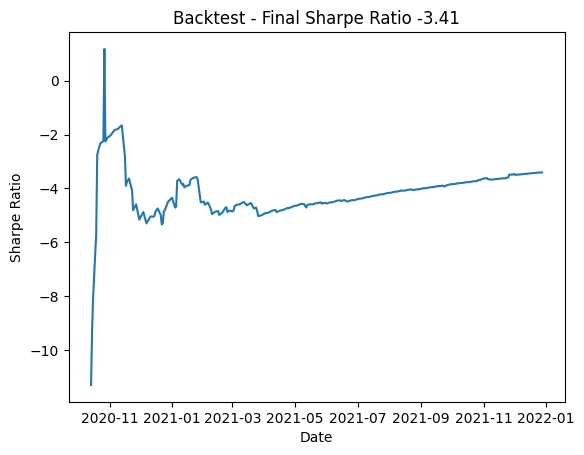

In [48]:
plt.plot(sharpe_df.index, sharpe_df['cumulative_sharpe'])
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title('Backtest - Final Sharpe Ratio {}'.format(sharpe_ratio))
plt.show()